# Setup

In [18]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

pd.options.display.max_rows = 999
pd.options.display.max_columns = 999

In [8]:
import xgboost as xgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [9]:
# Read raw data
df_X = pd.read_csv("../../../data/raw/train_values.csv")
df_y = pd.read_csv("../../../data/raw/train_labels.csv")
df_raw = df_X.merge(df_y, on='building_id')
df_raw_test = pd.read_csv("../../../data/raw/test_values.csv")

In [10]:
# Direcotry variables
dir_data_interim = "../data/interim/"
dif_data_clean = "../data/clean/"

In [20]:
# Read interim datasets
df_interim_train = pd.read_csv("{}train.csv".format(dir_data_interim))
df_interim_interim = pd.read_csv("{}val.csv".format(dir_data_interim))
df_interim_test = pd.read_csv("{}test.csv".format(dir_data_interim))

# Feature Selection

In [21]:
%%time
# Fit Initial XGB Classifier

X_train_init = df_interim_train.drop(['damage_grade', 'building_id'], axis=1).values
y_train_init = df_interim_train['damage_grade'].values

clf_xgb_init = xgb.XGBClassifier(
    objective='multiclass:softmax',
    random_state=3,
    n_estimators=50,
)

clf_xgb_init.fit(
    X_train_init,
    y_train_init,
    eval_set=[(X_train_init, y_train_init)],
    verbose=False
);

ValueError: could not convert string to float: 'v'

In [22]:
# Plot evaluation metrics by ntrees
plt.plot(clf_xgb_init.evals_result()['validation_0']['merror'], label='train')
plt.legend()
plt.show()

Exception ignored in: <bound method DMatrix.__del__ of <xgboost.core.DMatrix object at 0x1130e42e8>>
Traceback (most recent call last):
  File "/Users/aarontrefler_temp2/anaconda/envs/py35/lib/python3.5/site-packages/xgboost/core.py", line 482, in __del__
    if self.handle is not None:
AttributeError: 'DMatrix' object has no attribute 'handle'


AttributeError: 'XGBClassifier' object has no attribute 'evals_result_'

In [157]:
# Get feature importances
df_feats = (
    pd.DataFrame(clf_xgb_init.feature_importances_, columns=['feature'])
    .set_index(df_interim_train.drop(['damage_grade', 'building_id'], axis=1).columns)
)

# Define good features
feats_to_keep = df_feats.reset_index()['index'].loc[(df_feats.feature != 0).values].values
print("Dropping {} features".format(np.sum(df_feats == 0)[0]))
print("Keeping  {} features".format(np.sum(df_feats != 0)[0]))

Dropping 145 features
Keeping  52 features


In [6]:
# Define clean datasets
df_clean_train = df_interim_train.loc[:, feats_to_keep]
df_clean_interim = df_interim_val.loc[:, feats_to_keep]
df_clean_test = df_interim_clean.loc[:, feats_to_keep]

# Save clean datasetes
df_clean_train.to_csv("{}train.csv".format(dir_data_clean), index=False)
df_clean_interim.to_csv("{}val.csv".format(dir_data_clean), index=False)
df_clean_test.to_csv("{}test.csv".format(dir_data_clean), index=False)

NameError: name 'df_interim_train' is not defined

In [ ]:
# Read clean datasets
df_clean_train = pd.read_csv("{}train.csv".format(dir_data_clean), index=False)
df_clean_val = pd.read_csv("{}val.csv".format(dir_data_clean), index=False)
df_clean_test = pd.read_csv"{}test.csv".format(dir_data_clean), index=False)

# Model Training

In [ ]:
# Re-define datasets using only good features
X_train = df_clean_train.values
X_val = df_clean_val.values
X_test = df_clean_test.values

y_train = df_clean_train['damage_grade'].values
y_val = df_clean_val['damage_grade'].values

In [171]:
%%time
def f1_eval_metric(preds, dtrain):
    y_true = dtrain.get_label()
    y_pred = np.argmax(preds, axis=1)
    return 'f1', -1 * f1_score(y_true, y_pred, average='micro')

# Re-fit model using only good features
clf_xgb = xgb.XGBClassifier(
    objective='multiclass:softmax',
    random_state=3,
    base_score=1,
    n_estimators=150,
    learning_rate=0.5,
    subsample=0.8,
    colsample_bytree=0.8,
    max_depth=3,
    gamma=0.1
)

clf_xgb.fit(
    X_train,
    y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    eval_metric=f1_eval_metric,
    early_stopping_rounds=10,
    verbose=False
);

CPU times: user 1min 14s, sys: 192 ms, total: 1min 14s
Wall time: 1min 14s


In [177]:
# Predict
pred_train = clf_xgb.predict(X_train)
pred_val = clf_xgb.predict(X_val)
pred_test = clf_xgb.predict(X_test)

# Evaluate
score_train = f1_score(y_train.astype(int), pred_train.astype(int), average='micro')
score_val = f1_score(y_val.astype(int), pred_val.astype(int), average='micro')
print("Train f1 score: {}".format(score_train))
print("Val f1 score:   {}".format(score_val))

Train f1 score: 0.7700083618744344
Val f1 score:   0.734031791067338


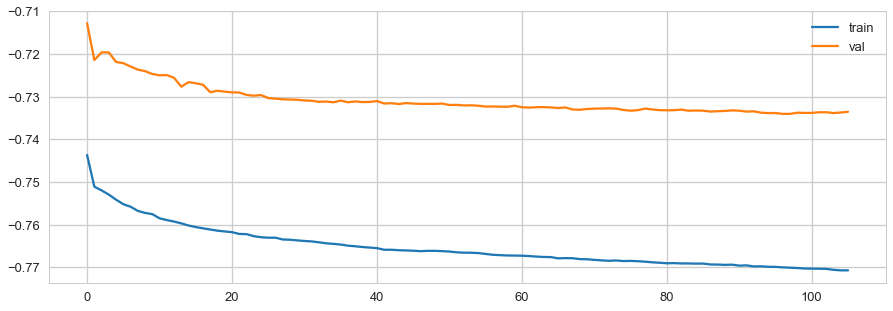

best ntree limit: 97


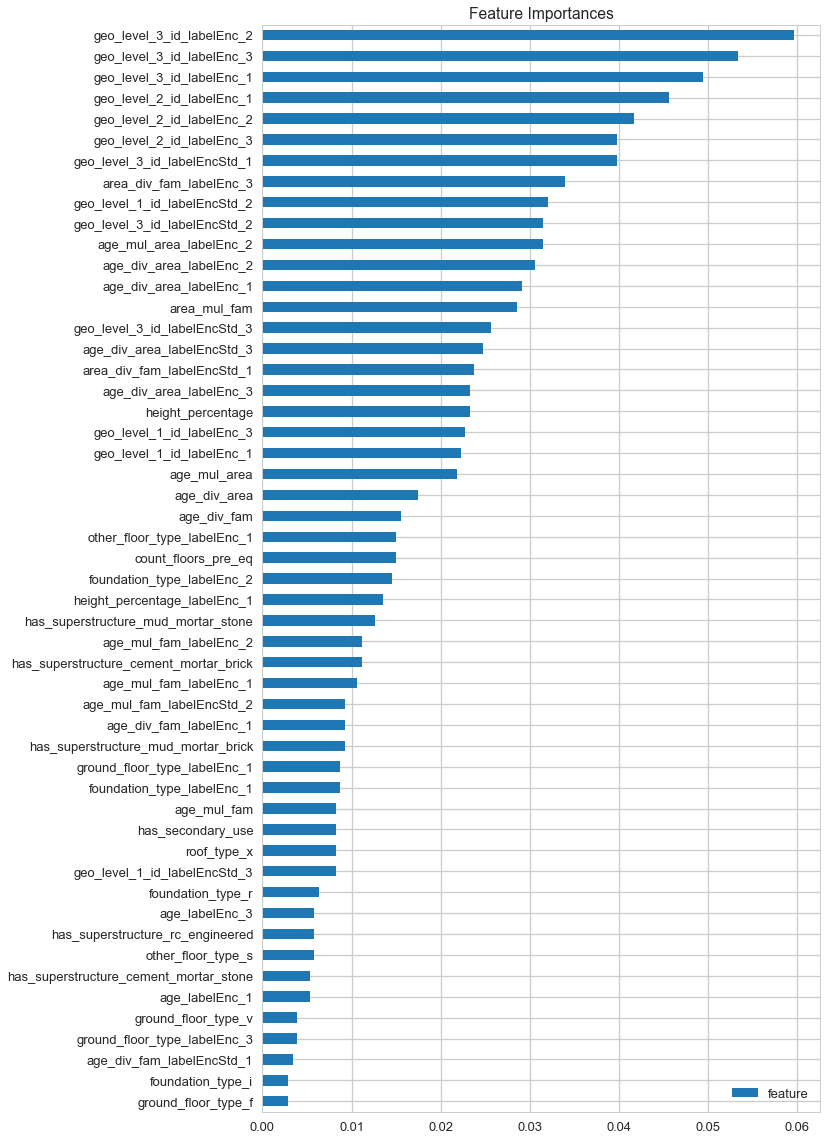

In [178]:
# Plot evaluation metrics by ntrees
plt.plot(clf_xgb.evals_result()['validation_0']['f1'], label='train')
plt.plot(clf_xgb.evals_result()['validation_1']['f1'], label='val')
plt.legend()
plt.show()
print("best ntree limit: {}".format(clf_xgb.best_ntree_limit))

# Plot feature importances
df_feats = (
    pd.DataFrame(clf_xgb.feature_importances_, columns=['feature'])
    .set_index(df_interim_train.loc[:, feats_to_keep].columns)
    .sort_values('feature')
)
df_feats.plot(kind='barh', figsize=(10, 20), title="Feature Importances")
plt.show()

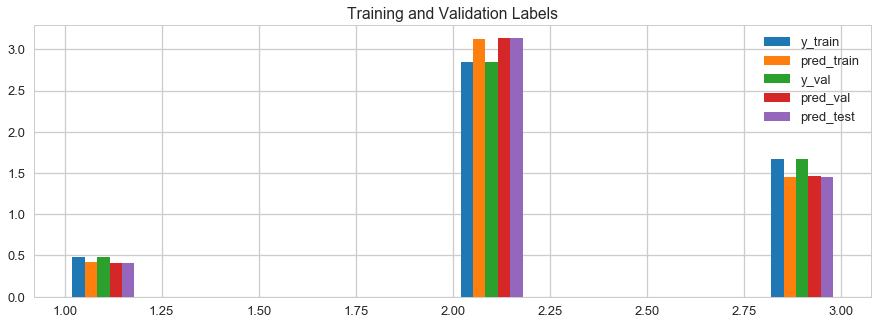

In [179]:
plt.figure(figsize=(15, 5))
plt.hist([y_train, pred_train, y_val, pred_val, pred_test], 
         density=True, 
         label=['y_train', 'pred_train', 'y_val', 'pred_val', 'pred_test'])
plt.title("Training and Validation Labels")
plt.legend()
plt.show()

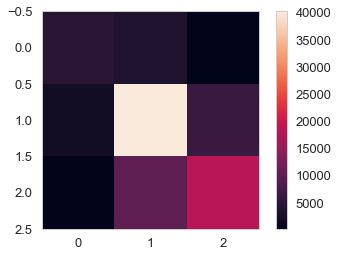

In [180]:
from sklearn.metrics import confusion_matrix
plt.imshow(confusion_matrix(y_val.astype(int), pred_val.astype(int)))
plt.colorbar()
plt.grid(False)
plt.show()

# Create Submission

In [184]:
%%time
Re-train on entire dataset
clf_xgb_final = clf_xgb
clf_xgb_final.n_estimators = clf_xgb.best_ntree_limit
clf_xgb_final.fit(
    np.concatenate((X_train, X_val)),
    np.concatenate((y_train, y_val)),
    verbose=False
)

# Make test set predictions
pred_test_final = clf_xgb_final.predict(X_test)

CPU times: user 728 ms, sys: 13.1 ms, total: 741 ms
Wall time: 739 ms


In [185]:
# Create submission file
import datetime
now = datetime.datetime.now()
(
    df_raw_test
    .assign(damage_grade=pred_test_final)
    .loc[:, ['building_id', 'damage_grade']]
    .to_csv("../models/{date}_submission_xgb.csv".format(date=now), index=False)
)

# Sandbox